In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from datetime import datetime
import numpy as np
import seaborn as sns
import sqlite3
import sys
import itertools
sys.path.insert(1, "../")
sys.path.insert(1, "../utilities")

from language_change_methods.utility_functions import tokenise, get_time_windows, get_data_windows
from language_change_methods.cross_entropy_models import BigramModel, SnapshotModels, SnapshotModelsPreset
from language_change_methods.cross_entropy_sampling import plot_group_similarity_across_runs_stepped, get_end_of_windows

from helpers import load_posts, load_toks, load_pos

convert_to_date = lambda x: datetime.strptime(x, "%Y/%m/%d %H:%M:%S")
OUT_DIR = "./Graphs"

from settings import TFES_FP, TFES_TOK_FP

In [2]:
def read_subreddit(db_fp):
    conn = sqlite3.connect(db_fp)
    comments = pd.read_sql_query("SELECT uid, time FROM comments", conn)
    comments.set_index("uid", inplace=True)
    comments['time'] = comments['time'].apply(convert_to_date)
    comments.sort_values("time", inplace=True)
    return comments

In [3]:
def get_align_toks(tok_fp, posts):
    # Get the corresponding tokens
    toks = {x[0]: x[1] for x in load_toks(tok_fp)}
    toks = pd.Series(toks)
    toks = toks[toks.index.isin(posts.index)]

    # Remove the posts that don't have tokens
    posts = posts[posts.index.isin(toks.index)]
    # Align the ordering of forum posts and toks
    toks = toks.loc[posts.index]

    return toks, posts

In [4]:
merge_lists = lambda x: list(itertools.chain.from_iterable(x))

In [5]:
def make_snapshots(posts, tok_fp):
    toks, posts = get_align_toks(tok_fp, posts)

    window_posts = {curr_date: curr_window
                       for curr_date, curr_window in get_data_windows(posts, 
                                                                      10000, 
                                                                      10000)}
    window_posts = pd.Series(window_posts)
    
    snaps = SnapshotModelsPreset(window_posts, toks)
    
    end_dates = get_end_of_windows(posts, get_data_windows, 10000, 10000)
    
    end_dates = pd.Series(end_dates, index=list(snaps.windows.keys()))
    
    return snaps, end_dates

In [6]:
forum_posts = load_posts(TFES_FP)

from helpers import flat_earth_boards, off_topic_boards as other_boards

fe_posts = forum_posts.query("board_id in @flat_earth_boards")

In [7]:
%%time
tfes_snaps, end_dates = make_snapshots(fe_posts, TFES_TOK_FP)

Wall time: 21.2 s


In [8]:
tfes_snaps.snapshots

{Timestamp('2013-12-01 18:43:04'): <language_change_methods.cross_entropy_models.BigramModel at 0x2e69cd784f0>,
 Timestamp('2015-12-30 23:54:31'): <language_change_methods.cross_entropy_models.BigramModel at 0x2e6d4d48e20>,
 Timestamp('2017-01-16 01:34:55'): <language_change_methods.cross_entropy_models.BigramModel at 0x2e738853100>,
 Timestamp('2017-11-09 16:57:19'): <language_change_methods.cross_entropy_models.BigramModel at 0x2e7388531f0>,
 Timestamp('2018-04-20 09:03:11'): <language_change_methods.cross_entropy_models.BigramModel at 0x2e7388532e0>,
 Timestamp('2018-10-07 05:55:37'): <language_change_methods.cross_entropy_models.BigramModel at 0x2e738853340>}

In [9]:
from settings import FE_REDDIT_DIR, OT_REDDIT_DIR

with open(os.path.join(FE_REDDIT_DIR, "subreddit_ace_info.json")) as curr_file:
    fe_subs_info = json.load(curr_file)
    
with open(os.path.join(OT_REDDIT_DIR, "subreddit_ace_info.json")) as curr_file:
    ot_subs_info = json.load(curr_file)

## Get CE for each FE subreddit

In [10]:
def get_chunks(idx, tokens, chunk_size):
    for i in range(0, len(tokens)-chunk_size, chunk_size):
        yield idx, tokens[i:i+chunk_size]
        
def make_tok_chunks(tokens, chunk_size):
    chunks = [[[idx, chunk] for idx, chunk in get_chunks(idx, curr_toks, chunk_size)] for idx, curr_toks in tokens.items()]
    chunks = merge_lists(chunks)
    chunks = pd.DataFrame(chunks, columns=["idx", "chunk"])
    return chunks

In [11]:
def get_sub_ce(sub_info, snapshots, curr_dir):
    curr_sub_name = sub_info["name"]
    comments = read_subreddit(os.path.join(curr_dir, f"{curr_sub_name}.db"))
    toks, comments = get_align_toks(os.path.join(curr_dir, "COMMENTS", f"{curr_sub_name}_comments.json"), comments)
    chunks =  make_tok_chunks(toks, 30)
    chunk_info = comments.loc[chunks["idx"]]
    chunk_info.index = chunks.index
    return snapshots.calculate_cross_entropies(chunks["chunk"], chunk_info["time"])

In [12]:
read_from_file = True

In [13]:
%%time
fe_sub_ce = dict()
for sub_info in fe_subs_info:
    sub_name = sub_info["name"]
    if read_from_file:
        fe_sub_ce[sub_name] = pd.read_csv(os.path.join(OUT_DIR, "CE", f"{sub_name}_ce_to_forum.csv"), 
                                          encoding="utf8", index_col=0, parse_dates=["date", "window"])
    else:
        fe_sub_ce[sub_name] = get_sub_ce(sub_info, tfes_snaps, FE_REDDIT_DIR)

Wall time: 773 ms


In [14]:
%%time
ot_sub_ce = dict()
for sub_info in ot_subs_info:
    sub_name = sub_info["name"]
    if read_from_file:
        ot_sub_ce[sub_name] = pd.read_csv(os.path.join(OUT_DIR, "CE", f"{sub_name}_ce_to_forum.csv"), 
                                          encoding="utf8", index_col=0, parse_dates=["date", "window"])
    else:
        ot_sub_ce[sub_name] = get_sub_ce(sub_info, tfes_snaps, OT_REDDIT_DIR)

Wall time: 2.13 s


In [15]:
%%time
if not read_from_file:
    for sub_name, ce in fe_sub_ce.items():
        ce.to_csv(os.path.join(OUT_DIR, "CE", f"{sub_name}_ce_to_forum.csv"), encoding="utf8")

    for sub_name, ce in ot_sub_ce.items():
        ce.to_csv(os.path.join(OUT_DIR, "CE", f"{sub_name}_ce_to_forum.csv"), encoding="utf8")

Wall time: 0 ns


## Plotting the CE

In [16]:
def get_ce_runs(chunk_ces, sample_size=None, n_samples=10):
    ce_runs = dict()
    for sub_name, ce in chunk_ces.items():
        if sample_size is None:
            curr_samp_size = int(0.5 * len(ce))
        
        curr_runs = [ce.sample(curr_samp_size, random_state=i).groupby("window").mean()["cross-entropy"] 
                     for i in range(n_samples)]
        curr_runs = pd.concat(curr_runs, axis=1)
        curr_runs.columns = range(n_samples)
        ce_runs[sub_name] = curr_runs
    return ce_runs

In [17]:
# Assign colours
colour_list = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "black", "#a65628", "#f781bf"]
marker_list = ["-", "-", ":", ":", "--", "--", "-.", "-."]

sub_names = list(fe_sub_ce)
fe_colour_dict = {sub: col for sub, col in zip(sub_names, colour_list)}
fe_marker_dict = {sub: mar for sub, mar in zip(sub_names, marker_list)}

sub_names = list(ot_sub_ce)
ot_colour_dict = {sub: col for sub, col in zip(sub_names, colour_list)}
ot_marker_dict = {sub: mar for sub, mar in zip(sub_names, marker_list)}

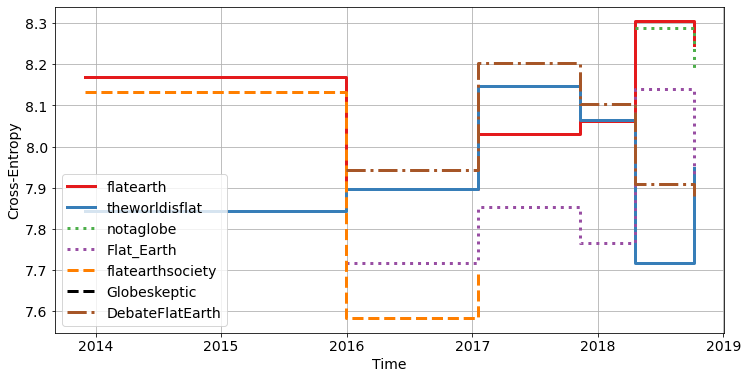

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))

for sub_name, ce in fe_sub_ce.items():
    avg_ce_over_time = ce.groupby("window").mean()["cross-entropy"]
    std_ce_over_time = ce.groupby("window").std()["cross-entropy"]
    
    ax.plot(avg_ce_over_time, label=sub_name, drawstyle='steps-post', 
            color=fe_colour_dict[sub_name], linestyle=fe_marker_dict[sub_name], lw=3)
    
    ax.set_xlabel("Time", fontsize=14)
    ax.set_ylabel("Cross-Entropy", fontsize=14)
    plt.setp(ax.get_xticklabels(), fontsize=14, rotation=0)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    
ax.grid()
ax.legend(fontsize=14)
plt.show()

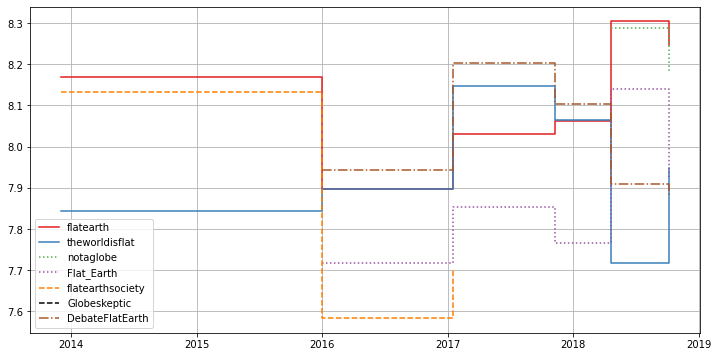

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))

for sub_name, ce in fe_sub_ce.items():
    avg_ce_over_time = ce.groupby("window").mean()["cross-entropy"]
    std_ce_over_time = ce.groupby("window").std()["cross-entropy"]
    
    ax.plot(avg_ce_over_time, label=sub_name, drawstyle='steps-post', 
            color=fe_colour_dict[sub_name], linestyle=fe_marker_dict[sub_name])
    
ax.grid()
ax.legend()
plt.show()

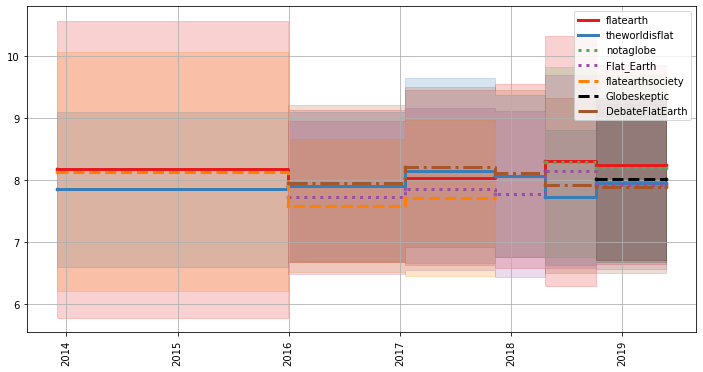

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))

for sub_name, ce in fe_sub_ce.items():
    avg_ce_over_time = ce.groupby("window").mean()["cross-entropy"]
    std_ce_over_time = ce.groupby("window").std()["cross-entropy"]
    
    curr_end_dates = end_dates.loc[avg_ce_over_time.index]
    
    plot_group_similarity_across_runs_stepped(avg_ce_over_time, 
                                              std_ce_over_time,
                                              ax, 
                                              colour=fe_colour_dict[sub_name], 
                                              line_style=fe_marker_dict[sub_name], 
                                              label=sub_name, 
                                              fill_alpha=0.2, end_dates=curr_end_dates)
    
ax.grid()
ax.legend()
plt.show()

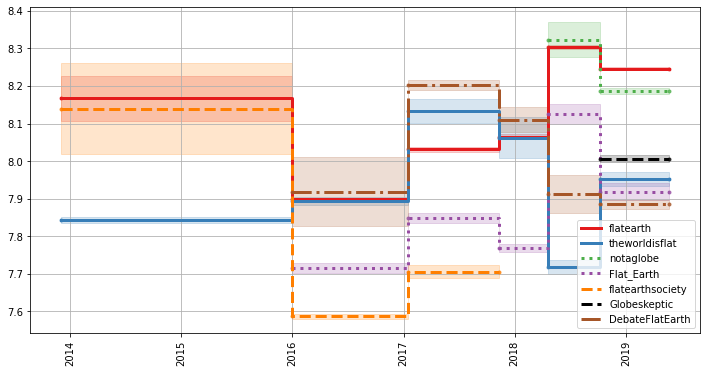

Wall time: 679 ms


In [21]:
%%time
fig, ax = plt.subplots(figsize=(12, 6))

ce_runs = get_ce_runs(fe_sub_ce)

for sub_name, ce_run in ce_runs.items():
    avg_ce_over_time = ce_run.mean(axis=1)
    std_ce_over_time = ce_run.std(axis=1)
    
    curr_end_dates = end_dates.loc[avg_ce_over_time.index]
    
    plot_group_similarity_across_runs_stepped(avg_ce_over_time, 
                                              std_ce_over_time,
                                              ax, 
                                              colour=fe_colour_dict[sub_name], 
                                              line_style=fe_marker_dict[sub_name], 
                                              label=sub_name, 
                                              fill_alpha=0.2, end_dates=curr_end_dates)
    
ax.grid()
ax.legend()
plt.show()

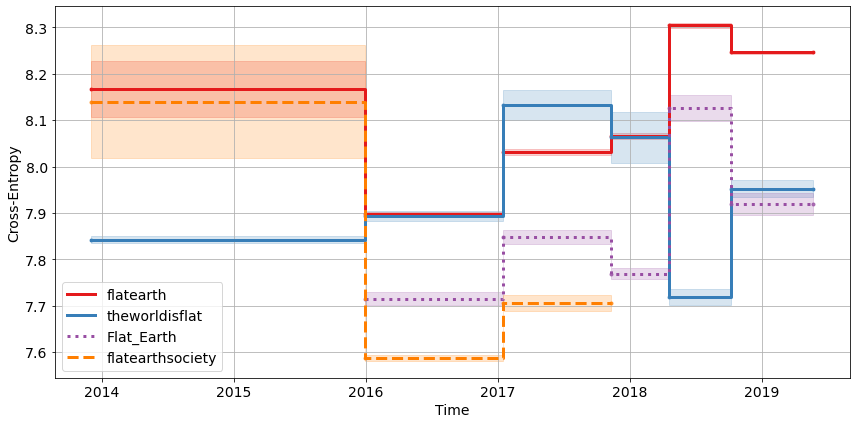

Wall time: 725 ms


In [22]:
%%time
fig, ax = plt.subplots(figsize=(12, 6))

ce_runs = get_ce_runs(fe_sub_ce)

ce_runs = {g: r for g, r in ce_runs.items() if g in ["flatearth", "flatearthsociety", "Flat_Earth", "theworldisflat"]}

for sub_name, ce_run in ce_runs.items():
    avg_ce_over_time = ce_run.mean(axis=1)
    std_ce_over_time = ce_run.std(axis=1)
    
    curr_end_dates = end_dates.loc[avg_ce_over_time.index]
    
    plot_group_similarity_across_runs_stepped(avg_ce_over_time, 
                                              std_ce_over_time,
                                              ax, 
                                              colour=fe_colour_dict[sub_name], 
                                              line_style=fe_marker_dict[sub_name], 
                                              label=sub_name, 
                                              fill_alpha=0.2, end_dates=curr_end_dates)
    

ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Cross-Entropy", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14, rotation=0)
plt.setp(ax.get_yticklabels(), fontsize=14)
    
ax.grid()
ax.legend(fontsize=14)
plt.tight_layout()
fig.savefig(os.path.join(OUT_DIR, "fe_reddit_ce_to_tfes.pdf"))
plt.show()

## Conspiracy and Science

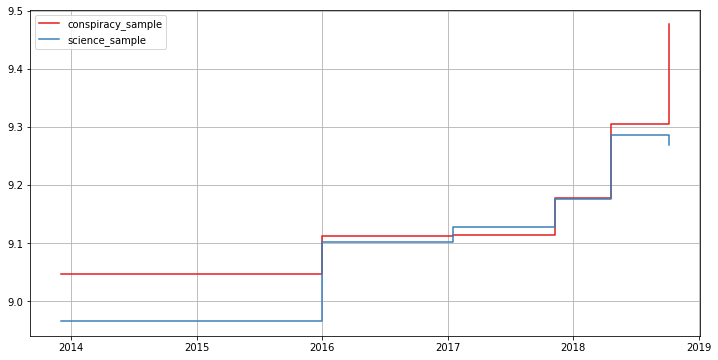

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))

for sub_name, ce in ot_sub_ce.items():
    avg_ce_over_time = ce.groupby("window").mean()["cross-entropy"]
    std_ce_over_time = ce.groupby("window").std()["cross-entropy"]
    
    ax.plot(avg_ce_over_time, label=sub_name, drawstyle='steps-post', 
            color=ot_colour_dict[sub_name], linestyle=ot_marker_dict[sub_name])
    
ax.grid()
ax.legend()
plt.show()

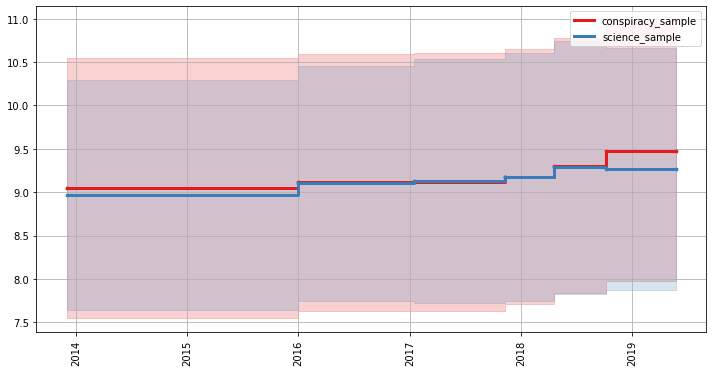

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))

for sub_name, ce in ot_sub_ce.items():
    avg_ce_over_time = ce.groupby("window").mean()["cross-entropy"]
    std_ce_over_time = ce.groupby("window").std()["cross-entropy"]
    
    curr_end_dates = end_dates.loc[avg_ce_over_time.index]
    
    plot_group_similarity_across_runs_stepped(avg_ce_over_time, 
                                              std_ce_over_time,
                                              ax, 
                                              colour=ot_colour_dict[sub_name], 
                                              line_style=ot_marker_dict[sub_name], 
                                              label=sub_name, 
                                              fill_alpha=0.2, end_dates=curr_end_dates)
    
ax.grid()
ax.legend()
plt.show()

In [25]:
ce_runs = get_ce_runs(ot_sub_ce)
ce_runs["conspiracy_sample"]

,0,1,2,3,4,5,6,7,8,9
window,,,,,,,,,,
2013-12-01 18:43:04,9.046949,9.047347,9.049544,9.047312,9.046835,9.049004,9.048337,9.046409,9.048118,9.044101
2015-12-30 23:54:31,9.118795,9.116449,9.104058,9.117656,9.120501,9.112853,9.106301,9.116155,9.113383,9.115042
2017-01-16 01:34:55,9.116693,9.115170,9.111764,9.110492,9.112787,9.119785,9.103201,9.114038,9.113332,9.116762
2017-11-09 16:57:19,9.176989,9.175027,9.181647,9.179344,9.183481,9.178294,9.171246,9.175914,9.183416,9.184746
2018-04-20 09:03:11,9.304179,9.316374,9.305748,9.304761,9.303806,9.305174,9.300993,9.300438,9.298960,9.296871
2018-10-07 05:55:37,9.479089,9.475314,9.474672,9.475617,9.477029,9.480880,9.476621,9.471708,9.476831,9.474216


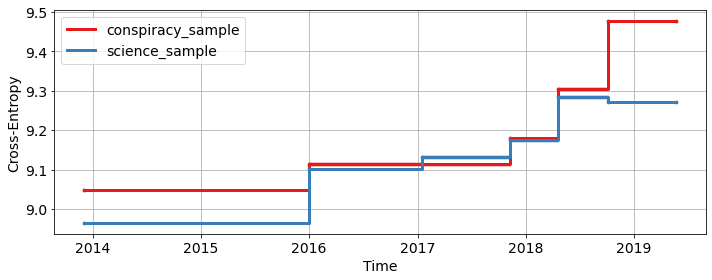

In [27]:
fig, ax = plt.subplots(figsize=(10, 4))

for sub_name, ce_run in ce_runs.items():
    avg_ce_over_time = ce_run.mean(axis=1)
    std_ce_over_time = ce_run.std(axis=1)
    
    curr_end_dates = end_dates.loc[avg_ce_over_time.index]

    
    plot_group_similarity_across_runs_stepped(avg_ce_over_time, 
                                              std_ce_over_time,
                                              ax, 
                                              colour=ot_colour_dict[sub_name], 
                                              line_style=ot_marker_dict[sub_name], 
                                              label=sub_name, 
                                              fill_alpha=0.2, end_dates=curr_end_dates)
    
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Cross-Entropy", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14, rotation=0)
plt.setp(ax.get_yticklabels(), fontsize=14)
    
ax.grid()
ax.legend(fontsize=14)

plt.tight_layout()

fig.savefig(os.path.join(OUT_DIR, "ot_reddit_ce_to_tfes.pdf"))
plt.show()